![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true" alt="Practicum AI: Computer Vision icon" align="right" width=50>
***

# Computer Vision Concepts

You may recall *Practicum AI*'s heroine Amelia, the AI-savvy nutritionist. At the end of our [*Deep Learning Foundations* course](https://practicumai.org/courses/deep_learning/), Amelia was helping with a computer vision project. Her colleague, an entomologist named Kevin, had a dataset of images of bees and wasps and wanted to classify them.

**For this exercise, we have made a subsample of those data to make training easier.**

![Image of bees and wasps from the dataset cover image](https://github.com/PracticumAI/deep_learning/blob/main/images/bees_wasps_dataset-cover.png?raw=true)


## AI Pathway review for Bees vs Wasps

If you have taken our [*Getting Started with AI* course](https://practicumai.org/courses/getting_started/), you may remember this figure of the **AI Application Development Pathway**. Let's take a quick review of how we applied this pathway in the case of the Bees vs Wasps example.

![AI Application Development Pathway image showing the 7 steps in developing an AI application](https://practicumai.org/getting_started/images/application_dev_pathway.png)

1. **Choose a problem to solve:** In this example, we need to classify images as bees, wasps, other insects, or a non-insect. 
2. **Gather data:** The data for the example come from [Kaggle](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp), a great repository of datasets, code, and models.
3. **Clean and prepare the data:** In the *Deep Learning Foundations* course, we assumed that this was done for us. One issue that we ran into was that of class imbalance. There are many more images in some classes than others, leading to a poor performing model. We won't address this yet, but will come back to it in notebook [01.2_data_imbalance.ipynb](01.2_data_imbalance.ipynb).
4. **Choose a model:** In the *Deep Learning Foundations* course, we presented the model with little detail. Now that we know more about Convolutional Neural Networks (CNNs) and some other tools at our disposal, we will explore the model in more detail.
   * As part of the iterative process of training models, one thing we noticed is that most of our models were **overfitting** — performing better on the training data than they did on the testing data. Essentially, the models memorized the training data but did not generalize well to new data that had not been seen. 
      * In this notebook, we will explore **dropout** as one mechanism to mitigate overfitting.
5. **Train the model:** In training the model we may have had a few issues. With so many hyperparameters to tune, it's easy to lose track of what combinations have been tried and how changes impacted model performance. 
   * In this notebook, we introduce you to [TensorBoard](https://www.tensorflow.org/tensorboard), one popular tool in a class of tools known as **experiment tracking** or **MLOps (Machine learning operations) tools**. These tools help track changes to hyperparameters, the training process, and the data. They allow comparison among runs and can even automate multiple runs for you. Learning to use MLOps tools will help you as you continue to learn more about AI workflows.
6. **Evaluate the model:** We will continue to assess how the model performs on the validation set and adjust the model and hyperparameters to attempt to produce a better model. However, as noted above in step 3, one issue we will continue to encounter is the class imbalance.    
   * This is a common issue with real data, and in notebook [01.2_data_imbalance.ipynb](01.2_data_imbalance.ipynb), we will explore some methods to handle this.
7. **Deploy the model:** We won"t get to this stage in this exercise, but hopefully, we will end up with a model that could be deployed and achieve relatively good accuracy at solving the problem.


## PyTorch and PyTorch Lightning

Since the introduction of the *Practicum AI* program, the AI landscape has shifted significantly (no real surprise there!!). While [TensorFlow](https://www.tensorflow.org/) seemed like a good choice at the time, and it can certainly be easier to get started with, the reality is that [Pytorch](https://pytorch.org/) has gained much more popularity. At this point, the *Practicum AI* team has made the decision to transition our code to use Pytorch. 

### PyTorch Lightning 

<img src='images/Lightning_logo.svg' alt="PyTorch Lightning logo" width="20%" align="right">

[PyTorch Lightning](https://lightning.ai/) is an open-source framework built on top of PyTorch that makes training deep learning models more straightforward. It abstracts many common tasks like managing training loops, logging, checkpointing, and handling hardware setups, allowing you to focus on the core aspects of your model and experimentation. 

Rather than writing repetitive code, you define key methods—such as `training_step` and `validation_step`—to describe the model's behavior while the Lightning trainer automates optimization details, synchronization, and even distributed training. This separation between scientific code and engineering routines leads to cleaner, more maintainable projects that are easier to scale.

Additionally, PyTorch Lightning integrates smoothly with popular tools such as [TensorBoard](https://www.tensorflow.org/tensorboard), which simplifies tracking experiment metrics and visualizing performance. Overall, Lightning streamlines the training workflow, boosts reproducibility, and helps both beginners and seasoned researchers concentrate on innovation, not boilerplate coding.

This course will make use of Lightning to simplify training.

Over time, the Beginner Series of courses will also be updated to have Pytorch versions.

## Outline of this notebook

This notebook covers a fair bit of ground. To orient you, here's an outline of the topics covered. Note that you can also open the notebook outline to see section headers.

1. Run through loading the data and exploring it a bit ([sections 1](#1.-Import-the-libraries-we-will-use) through 5).
1. Set initial hyperparameters, train a CNN model, and evaluate the performance ([sections 6](#6.-Make-our-model) through 8).
1. Explore Tensorboard as a tool to gain more insight into model performance ([section 9](#9.-View-training-metrics-in-TensorBoard)).
1. Spend some time tuning hyperparameters and evaluating the impact on model performance ([section 10](#10.-Explore-hyperparameters!))
1. Summarize the results obtaiend so far ([section 11](#11.-Summary-so-far))
1. Explore what a convolutional kernel is in more detail, visualizing kernels and convolved images ([section 12](#12.-A-look-inside-CNNs))
1. Add dropout to our model ([section 13](#13.-Dropout)) and discuss the padding and stride hyperparameters ([section 14](#14.-Padding-and-stride-for-convolutional-layers))
1. Conclude with a summary of the results and motivate the next notebook ([section 15](#15.-Conclusion))

## 1. Import the libraries we will use

In [1]:
import torch
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
import random


from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image

from sklearn.model_selection import train_test_split
import pytorch_lightning as pl

# Many functions are moved to helpers_01.py to keep this file clean.
import helpers_01

# Set seed for reproducibility
pl.seed_everything(42)


[rank: 0] Seed set to 42


42

## 2. Check PyTorch installation

In [2]:
# Print Pytorch versions and check for GPU
print(f'Pytorch version: {torch.__version__}')
print(f'  Should be "True" if Pytorch was built for GPU: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'  Available GPU: {torch.cuda.get_device_name()}')
else:
    print('  No GPU available, will use CPU')

Pytorch version: 2.7.1+cu128
  Should be "True" if Pytorch was built for GPU: True
  Available GPU: NVIDIA B200
  Available GPU: NVIDIA B200


## 3. Getting the data

For details about the dataset and the code used to get the data you can look at the [helpers_01.py file](helpers_01.py). 

If you need to download the data, it is [hosted for public download from HiPerGator as a `tar.gz` file](https://data.rc.ufl.edu/pub/practicum-ai/Deep_Learning_Foundations/bee_vs_wasp.tar.gz). If you need to manually extract the data, you can add a cell and run: `helpers_01.extract_file("bee_vs_wasp.tar.gz", "data")`


In [3]:
# Check for the data.
# This will look for the data files required for this notebook in some common locations.
#   * If it can't find the data, it will ask if you know where it is. 
#   * If you do, answer yes and provide the path to the data 
#       (up to and including the `bee_vs_wasp` folder name). 
#   * If not, it will ask if you want to download it. 
#      * If you answer yes, it will download the data and
#        extract it into your data folder.

data_path = helpers_01.manage_data(folder_name='bee_vs_wasp_reduced',)

Found data at data/bee_vs_wasp_reduced.


## 4. Setting the number of workers

One of the really great things about Pytorch Lightning is that it can efficiently use multiple CPUs (or cores) to do things like load data. This can be important in keeping the GPU fed with data rather that sitting idle waiting for data.

The cell below will set the number of workers, using a manually set number (change `None` in the first line of code to an integer), a number from the Slurm scheduler used on many computer clusters, or the number of CPU cores on the computer. 

In [4]:
# Set the number of workers to use for data loading
num_workers = None  # To manually set the number of workers, change this to an integer

if num_workers is None:
    # If Slurm is being used, set the number of workers to a Slurm-provided value.
    # If Slurm is not being used, set the number of workers to the number of available CPU cores.
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
    elif os.getenv("SLURM_NTASKS_PER_NODE") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS_PER_NODE"))
    elif os.getenv("SLURM_NTASKS") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS"))
    else:
        num_workers = os.cpu_count()

print(f"Using {num_workers} workers for data loading.")

Using 4 workers for data loading.


## 5. Examine some images

Many of the steps in this notebook are written as functions, making it easier to run these steps repeatedly as you work on optimizing the various hyperparameters.

The `helpers_01.load_display_data()` function takes: 
* A path to the data: set from above.
* The batch size: set as 32 below, but a good hyperparameter to tune.
* Target shape for images: set as 80x80 color images below, another possible hyperparameter.
* Whether or not to show sample images.
* The train/validation split
* The number of workers

The function returns training and validation datasets. To help highlight the class imbalance issue, the function has been updated to report the numbers of images and percent of the total in each class.

******************************************************************
Load data:
  - Loading the dataset from: data/bee_vs_wasp_reduced.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 4 workers for data loading
  - Returning class counts for later use? False
******************************************************************

For the full dataset: 
   Class          # of images     # of total
--------------------------------------------
            bee         249         24.7%
   other_insect         254         25.2%
 other_noinsect         252         25.0%
           wasp         252         25.0%
--------------------------------------------
The classes in your dataset are: ['bee', 'other_insect', 'other_noinsect', 'wasp']


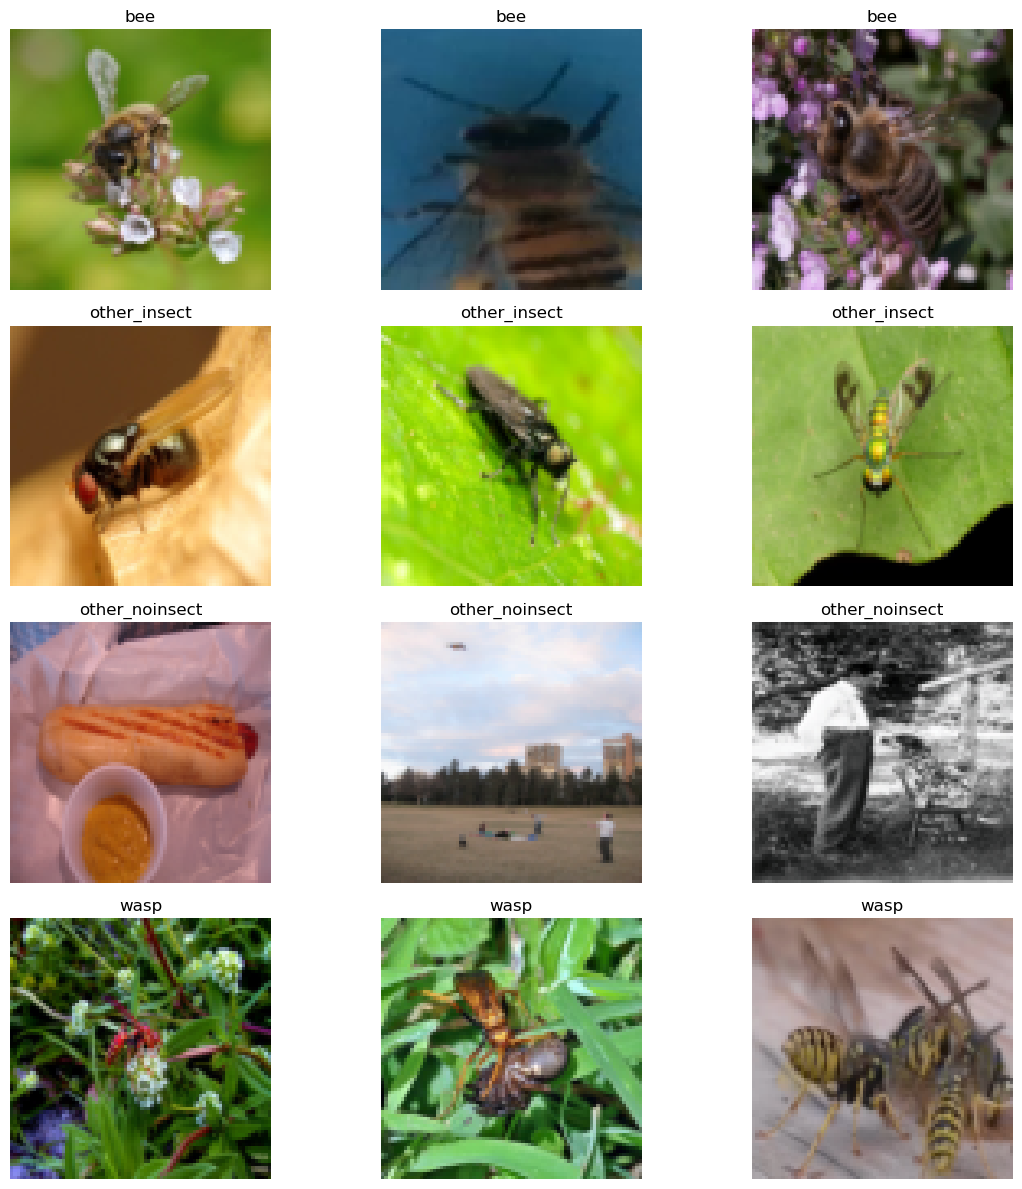

In [5]:
# Use the Lightning DataModule from helpers_01
data_module = helpers_01.load_display_data(
    data_path, 
    batch_size=32, 
    shape=(80, 80, 3), 
    show_pictures=True,
    train_split=0.8,  # 80% train, 20% validation
    num_workers=num_workers     # Number of workers for data loading
)

## 6. Train the Model

Using PyTorch Lightning's standard patterns, we create a LightningModule that defines:

- **Model architecture** in `__init__` and `forward`
- **Training logic** in `training_step` 
- **Validation logic** in `validation_step`
- **Optimizer configuration** in `configure_optimizers`
- **Built-in metrics** using Lightning's torchmetrics integration

The training process is handled by Lightning's `Trainer` which provides:
- Automatic GPU/CPU handling
- Built-in logging to TensorBoard
- Model checkpointing and early stopping
- Progress bars and model summaries

In [6]:
# Train the model using standard PyTorch Lightning approach
model, trainer = helpers_01.train_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=10,
    accelerator='auto',  # Lightning will choose GPU if available
    devices='auto',      # Lightning will choose optimal device count
    input_shape=(3, 80, 80)  # Match the shape used in data loading
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA B200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA B200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 896    | train
1 | conv2          | Conv2d             | 18.5 K | train
2 | pool           | MaxPool2d          | 0      | train
3 | dropout        | Dropout            | 0      | train
4 | relu           | ReLU               | 0      | train
5 | fc1            | Linear             | 3.3 M  | train
6 | fc2            | Linear             | 516    | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccuracy | 0      | train
9 | test_accuracy  | MulticlassAccuracy | 0      | train
-------------------------------------

/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|█| 26/26 [00:01<00:00, 17.56it/s, v_num=4, train_loss_step=0.224, val_loss=

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 26/26 [00:01<00:00, 17.44it/s, v_num=4, train_loss_step=0.224, val_loss=



## 7. Evaluate the model

The `test_model` function will now provide comprehensive evaluation including:
- Test accuracy and loss metrics
- Training and validation loss curves over epochs
- Training and validation accuracy curves over epochs  
- Confusion matrix showing prediction accuracy per class
- Per-class precision, recall, and F1 scores

These visualizations help us understand:
- **Loss curves**: Whether the model is overfitting (validation loss increases while training loss decreases)
- **Accuracy curves**: How well the model generalizes to unseen data
- **Confusion matrix**: Which classes the model confuses with each other
- **Per-class metrics**: How well the model performs on each individual class

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|████████████████████████████████| 7/7 [00:00<00:00, 24.52it/s]
──────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6584158539772034
        test_loss           0.8874596357345581
──────────────────────────────────────────────────────────────────────────────────────────

──────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6584158539772034
        test_loss           0.8874596357345581
──────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'val_loss', 'val_acc', 'epoch', 'train_loss_epoch'

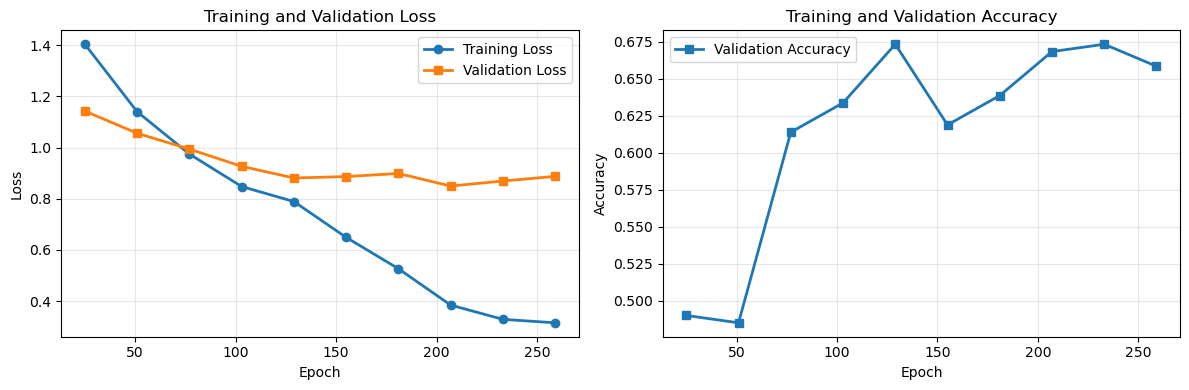

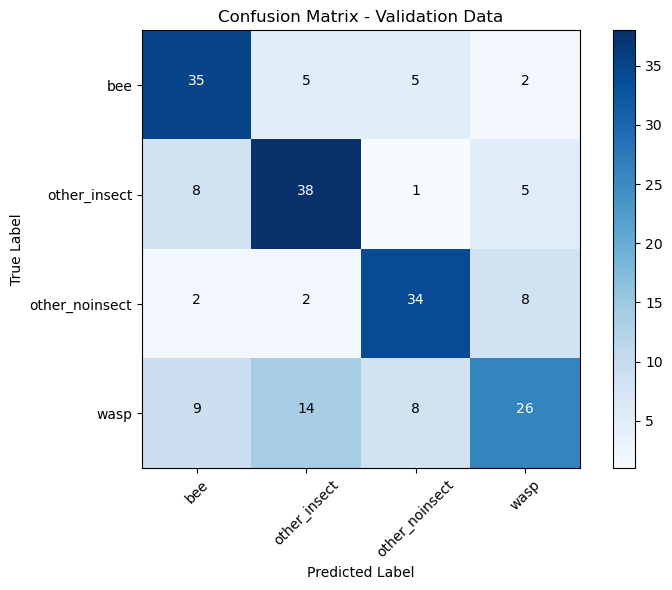


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.648, Recall=0.745, F1=0.693
   other_insect: Precision=0.644, Recall=0.731, F1=0.685
 other_noinsect: Precision=0.708, Recall=0.739, F1=0.723
           wasp: Precision=0.634, Recall=0.456, F1=0.531


In [7]:
# Test the model and display comprehensive evaluation plots
# The debug output will show us what TensorBoard metrics are actually available
test_results = helpers_01.test_model(data_module, model, trainer)

## 9. View training metrics in TensorBoard

Now that we've run one training cycle, we can open TensorBoard and have a look at the visualizations it provides to evaluate training performance.

The detailed instructions for different platforms are in the course content. In general, we use the `tensorboard --logdir ./logs` command to start TensorBoard and then connect in a Web browser. Here's a screenshot of what that might look like:

![Screenshot of the TensorBoard web page](images/tensorboard_screenshot.png)

In [8]:
# View TensorBoard logs
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## 11. Summary so far

Some of the points we can take away so far include:

* Most of the time, our model struggles to do better than about 70% accuracy on the validation data. Accuracy on the training data is closer to 90%. This suggests that our model is overfit to the training data.

Before we move on to working more to improve the model, let's take a quick look at the inner workings of the convolutional kernels.

## 12. A look inside CNNs
To get an idea for what is happening *inside* this model, let's look at a **feature map**. Below we see a vertical edge detection filter applied to a sunflower picture, resulting in a feature map of that image.

![Two pictures of a sunflower. On the left is the original image, on the right is the convolved image resulting from applying an edge detecting convolutional filter.](images/filtered_sunflower_nb01.jpg)

Imagine you're a detective investigating a scene.  A feature map is like a sketch you create, focusing on specific details that might be clues to solving the case.  In a CNN, the "case" is recognizing patterns in an image, and the feature maps capture these patterns at different levels of complexity. Early layers might create feature maps that detect basic edges, corners, or blobs of color. As the network progresses through more layers, the feature maps become more intricate, combining these simpler features to represent more complex objects or shapes.

Getting a bit more technical, a feature map is a 2D array of activations produced by applying a convolutional filter to an input image or a previous layer's feature map. It essentially captures the presence and strength of specific visual features the filter is optimized to detect within the input.

The **convolutional filters** (also just called "filters" or "kernels") are small matrices containing learnable weights. The filter "slides" across the input image, performing element-wise multiplication with the underlying image data at each position. The results of the multiplications are summed and then passed through an activation function (like ReLU) to introduce non-linearity and help the network learn complex features. A convolutional layer typically has multiple filters, each generating a separate feature map. These feature maps capture different aspects of the input, providing a richer representation of the image.

**NOTE**: The above sunflower example could potentially be a bit misleading. While a model *might* develop a vertical edge detection filter, the model develops its filters' weights through the same backpropagation process as other deep neural networks. Most of the filters, and their resulting feature maps, will not be as easily interpretable as the vertical edge detection filter.

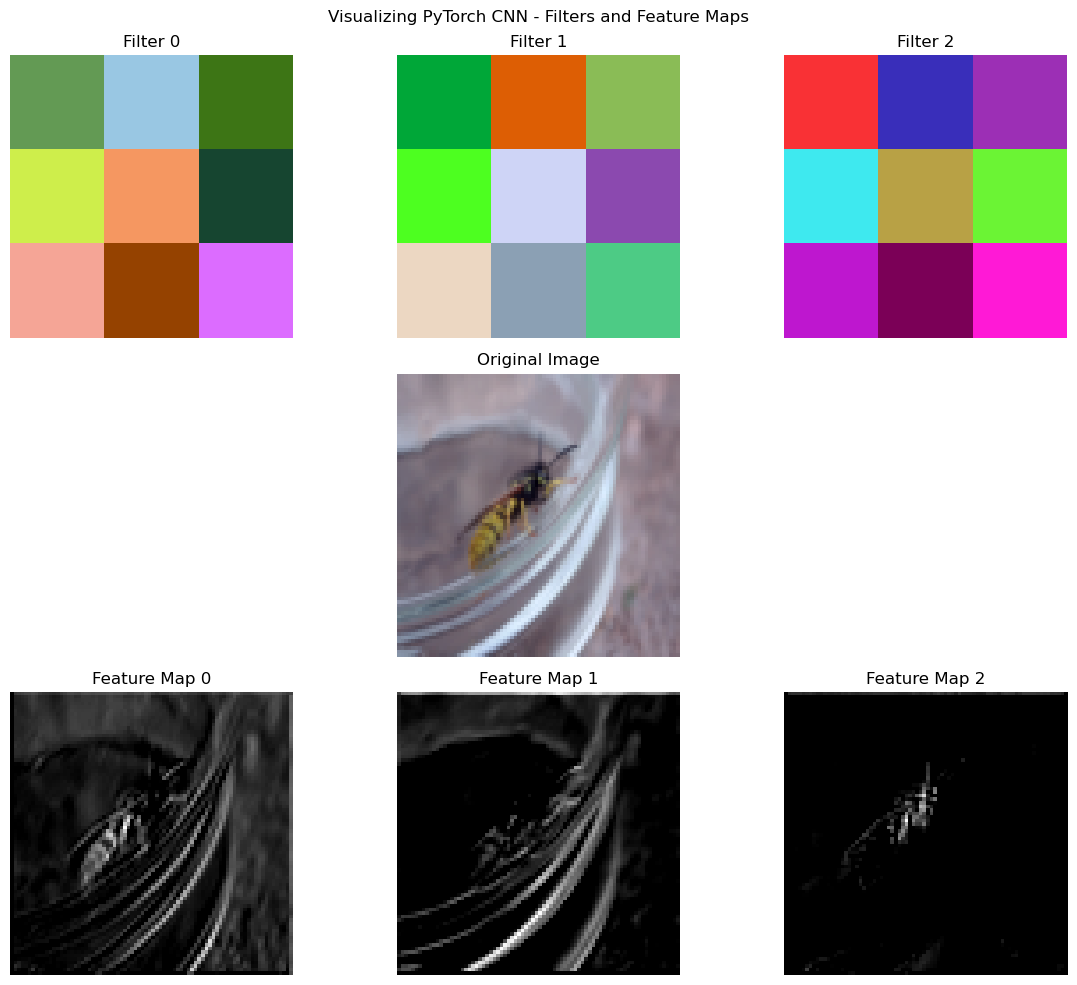

Filter weights shape: (32, 3, 3, 3)
Sample image shape: torch.Size([1, 3, 80, 80])
Feature maps after conv1 shape: (1, 32, 80, 80)
Sample image label: 3


In [9]:

# Get the filters from the first convolutional layer of the PyTorch model
model.eval()  # Set model to evaluation mode
filters = model.conv1.weight.data.cpu().numpy()  # Shape: (out_channels, in_channels, height, width)

# Get the first batch of images from the validation set
val_loader = data_module.val_dataloader()
images, labels = next(iter(val_loader))

# Take only the first image for visualization
sample_image = images[0:1]  # Keep batch dimension
sample_label = labels[0]

# Ensure the input tensor is on the same device as the model
device = next(model.parameters()).device
sample_image = sample_image.to(device)

# Get feature maps from the first conv layer
with torch.no_grad():
    # Forward pass through first conv + relu + pool
    x = model.relu(model.conv1(sample_image))
    feature_maps_conv1 = x.cpu().numpy()
    feature_maps_pool1 = model.pool(x).cpu().numpy()

# Convert sample image to numpy for display
sample_image_np = sample_image[0].permute(1, 2, 0).cpu().numpy()

# Normalize the filters and feature maps for better visualization
# PyTorch filters have shape (out_channels, in_channels, height, width)
# We'll take the first 3 filters and visualize them
num_filters = min(3, filters.shape[0])
normal_filters = (filters - filters.min()) / (filters.max() - filters.min())

plt.figure(figsize=(12, 10))

# ----- Display First 3 Filters -----
for i in range(num_filters):
    # Get the i-th filter (shape: in_channels, height, width)
    filter_weights = normal_filters[i]  # Shape: (3, 3, 3) for RGB input
    
    # Create RGB visualization by treating channels as RGB
    if filter_weights.shape[0] == 3:  # RGB input
        # Rearrange from (C, H, W) to (H, W, C) for display
        filter_rgb = np.transpose(filter_weights, (1, 2, 0))
        # Normalize to [0, 1] range
        filter_rgb = (filter_rgb - filter_rgb.min()) / (filter_rgb.max() - filter_rgb.min())
    else:
        # For non-RGB, just show the first channel
        filter_rgb = filter_weights[0]
    
    plt.subplot(3, 3, i + 1)
    if len(filter_rgb.shape) == 3:
        plt.imshow(filter_rgb)
    else:
        plt.imshow(filter_rgb, cmap='gray')
    plt.title(f"Filter {i}")
    plt.axis("off")

# ----- Original Image -----
plt.subplot(3, 3, 5)  # Center position
# Normalize image for display (assuming it's normalized for training)
img_display = sample_image_np.copy()
# If image was normalized during training, denormalize it
img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
plt.imshow(img_display)
plt.title("Original Image")
plt.axis("off")

# ----- Feature Maps from First Conv Layer -----
num_feature_maps = min(3, feature_maps_conv1.shape[1])
for i in range(num_feature_maps):
    plt.subplot(3, 3, i + 7)  # Bottom row
    feature_map = feature_maps_conv1[0, i, :, :]  # Get i-th feature map
    plt.imshow(feature_map, cmap="gray")
    plt.title(f"Feature Map {i}")
    plt.axis("off")

plt.suptitle("Visualizing PyTorch CNN - Filters and Feature Maps")
plt.tight_layout()
plt.show()

# Print some information about the shapes
print(f"Filter weights shape: {filters.shape}")
print(f"Sample image shape: {sample_image.shape}")
print(f"Feature maps after conv1 shape: {feature_maps_conv1.shape}")
print(f"Sample image label: {sample_label}")

The learned weights for each of the color channel pixel intensity values of the filters above are printed inside their rendered cells (the weights for the red channel are in red, green in green, and blue in blue). The colors of the filters are shown for illustrative purposes, its the weights that matter!

As mentioned above, the feature maps you see may not be as easily interpretable as the edge detection filter to us, but they *are* useful to the model. They help the model learn to recognize patterns in the images. You can rerun the cell above to see the feature maps for different images.

Below we'll look at a few more feature maps, this time from the first, second, and third convolutional layers of our model. This will give us an idea of what the model is learning at different levels of abstraction. In first Module we explained that each layer looks at a larger area of the image, so the feature maps from the first layer will be more detailed than those from the second layer, and so on.

> **NOTE:** If you have changed the model architecture, you may need to adjust the layer numbers below!


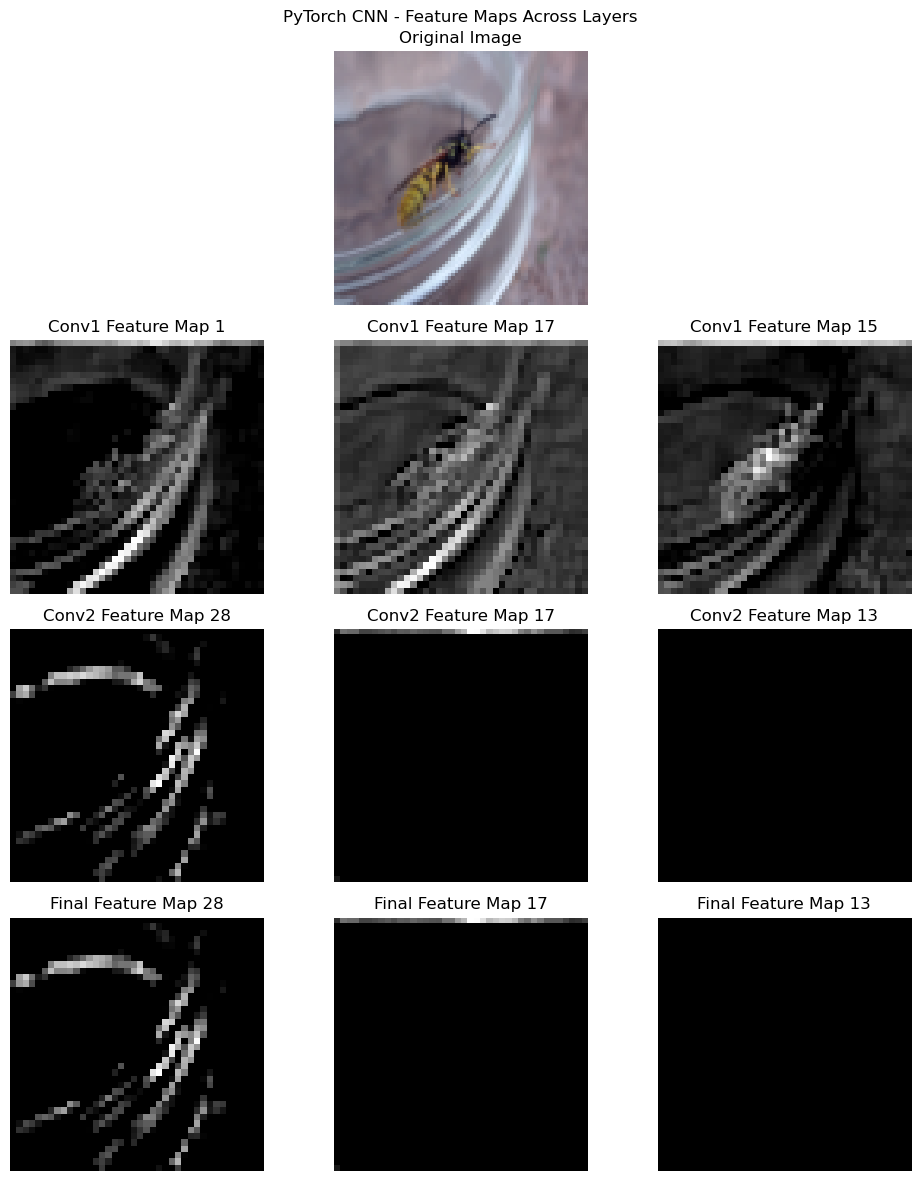

Original image shape: torch.Size([1, 3, 80, 80])
Conv1 feature maps shape: (1, 32, 40, 40)
Conv2 feature maps shape: (1, 64, 40, 40)
Selected Conv1 feature map indices: [1, 17, 15]
Selected Conv2 feature map indices: [28, 17, 13]


In [10]:

# Get feature maps from different layers of the PyTorch model
model.eval()

# Get the first batch of images from the validation set
val_loader = data_module.val_dataloader()
images, labels = next(iter(val_loader))

# Take only the first image for visualization
sample_image = images[0:1]  # Keep batch dimension

# Ensure the input tensor is on the same device as the model
device = next(model.parameters()).device
sample_image = sample_image.to(device)

with torch.no_grad():
    # Get feature maps from first conv layer (after ReLU and pooling)
    x1 = model.relu(model.conv1(sample_image))
    feature_maps_conv1 = model.pool(x1).cpu().numpy()
    
    # Get feature maps from second conv layer (after ReLU and pooling)
    x2 = model.relu(model.conv2(x1))
    feature_maps_conv2 = model.pool(x2).cpu().numpy()
    
    # The "last" layer would be the final conv layer (conv2 in our simple model)
    # So we'll use conv2 as both middle and last for demonstration
    feature_maps_last = feature_maps_conv2

# Convert sample image to numpy for display
sample_image_np = sample_image[0].permute(1, 2, 0).cpu().numpy()
sample_image_np = (sample_image_np - sample_image_np.min()) / (sample_image_np.max() - sample_image_np.min())

# Select random feature maps to display
num_filters_conv1 = feature_maps_conv1.shape[1]
num_filters_conv2 = feature_maps_conv2.shape[1]

# Ensure we don't try to select more indices than available
random_indices_conv1 = random.sample(range(num_filters_conv1), min(3, num_filters_conv1))
random_indices_conv2 = random.sample(range(num_filters_conv2), min(3, num_filters_conv2))
random_indices_last = random_indices_conv2  # Same as conv2 for our simple model

plt.figure(figsize=(10, 12))

# ----- Original Image -----
plt.subplot(4, 3, 2)  # Position 2 in top row
plt.imshow(sample_image_np)
plt.title("Original Image")
plt.axis("off")

# ----- First Layer Feature Maps (Conv1 + Pool) -----
for i, idx in enumerate(random_indices_conv1):
    plt.subplot(4, 3, i + 4)  # Second row: positions 4, 5, 6
    feature_map = feature_maps_conv1[0, idx, :, :]
    plt.imshow(feature_map, cmap="gray")
    plt.title(f"Conv1 Feature Map {idx}")
    plt.axis("off")

# ----- Second Layer Feature Maps (Conv2 + Pool) -----
for i, idx in enumerate(random_indices_conv2):
    plt.subplot(4, 3, i + 7)  # Third row: positions 7, 8, 9
    feature_map = feature_maps_conv2[0, idx, :, :]
    plt.imshow(feature_map, cmap="gray")
    plt.title(f"Conv2 Feature Map {idx}")
    plt.axis("off")

# ----- "Last" Layer Feature Maps (same as Conv2 for our simple model) -----
for i, idx in enumerate(random_indices_last):
    plt.subplot(4, 3, i + 10)  # Fourth row: positions 10, 11, 12
    feature_map = feature_maps_last[0, idx, :, :]
    plt.imshow(feature_map, cmap="gray")
    plt.title(f"Final Feature Map {idx}")
    plt.axis("off")

plt.suptitle("PyTorch CNN - Feature Maps Across Layers")
plt.tight_layout()
plt.show()

# Print information about the feature map shapes
print(f"Original image shape: {sample_image.shape}")
print(f"Conv1 feature maps shape: {feature_maps_conv1.shape}")
print(f"Conv2 feature maps shape: {feature_maps_conv2.shape}")
print(f"Selected Conv1 feature map indices: {random_indices_conv1}")
print(f"Selected Conv2 feature map indices: {random_indices_conv2}")

Just as with the other hyperparameters in Section 5 above, the number of filters, the size of the filters, and the stride of the filters are all hyperparameters that can be adjusted. You can also add or remove convolutional and pooling layers, or add dropout layers.


## 13. Dropout

Dropout layers are a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training. In PyTorch, you can add dropout using:
    
```python
   nn.Dropout(0.5)  # 50% dropout rate
```

## 14. Padding and stride for convolutional layers

In PyTorch, you can adjust the stride and padding of convolutional layers using the `stride` and `padding` arguments in `nn.Conv2d`. The `stride` parameter controls how much the filter moves at each step, while `padding` adds zeros around the input. Here are some examples:

```python
    # Standard convolutional layer with padding=1 (keeps spatial dimensions roughly the same)
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    
    # Convolutional layer with stride=2 (reduces spatial dimensions by half)
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
    
    # MaxPooling layer (typically no padding needed)
    nn.MaxPool2d(kernel_size=2, stride=2)
```

The `train_model` function accepts `dropout_rate` and `conv_padding` parameters, allowing you to experiment with different configurations to reduce overfitting and control the spatial dimensions of your feature maps.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training model with high dropout (0.7) to reduce overfitting...



  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 896    | train
1 | conv2          | Conv2d             | 18.5 K | train
2 | pool           | MaxPool2d          | 0      | train
3 | dropout        | Dropout            | 0      | train
4 | relu           | ReLU               | 0      | train
5 | fc1            | Linear             | 3.3 M  | train
6 | fc2            | Linear             | 516    | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccuracy | 0      | train
9 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.187    Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handler

/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 8: 100%|█| 26/26 [00:01<00:00, 20.82it/s, v_num=5, train_loss_step=0.765, val_loss=

Model with dropout - check for reduced overfitting
Model with dropout - check for reduced overfitting


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|████████████████████████████████| 7/7 [00:00<00:00, 25.53it/s]
──────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6435643434524536
        test_loss           0.8930414915084839
──────────────────────────────────────────────────────────────────────────────────────────

──────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6435643434524536
        test_loss           0.8930414915084839
──────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'val_loss', 'val_acc', 'epoch', 'train_loss_epoch'

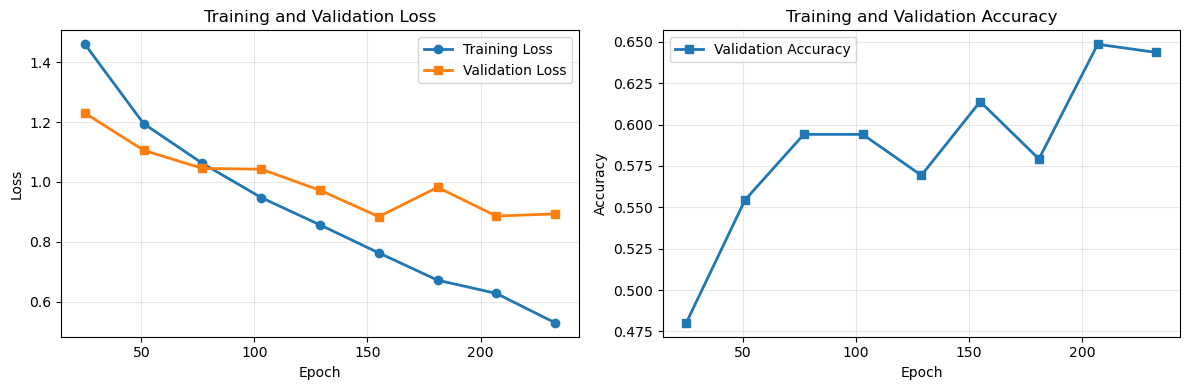

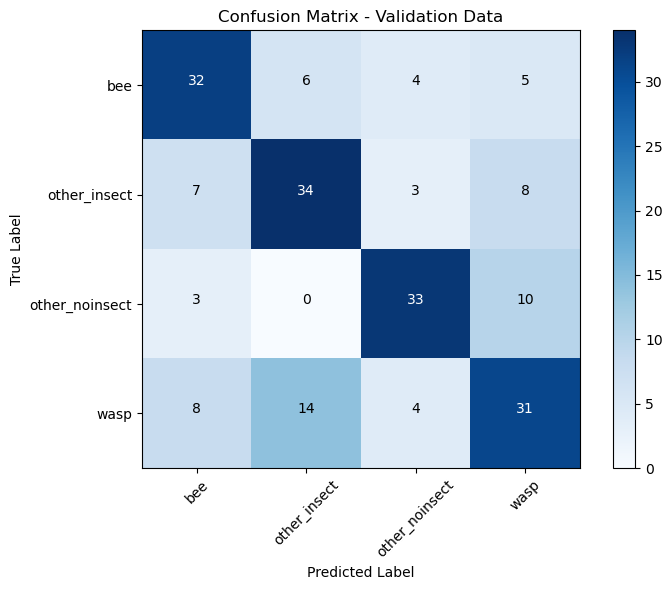


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.640, Recall=0.681, F1=0.660
   other_insect: Precision=0.630, Recall=0.654, F1=0.642
 other_noinsect: Precision=0.750, Recall=0.717, F1=0.733
           wasp: Precision=0.574, Recall=0.544, F1=0.559


[{'test_loss': 0.8930414915084839, 'test_acc': 0.6435643434524536}]

In [11]:
# Example: Train a model with different dropout and padding settings

# Example 1: High dropout to reduce overfitting
print("Training model with high dropout (0.7) to reduce overfitting...")
model_dropout, trainer_dropout = helpers_01.train_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=10,  # Fewer epochs for demonstration
    dropout_rate=0.5,  # Add a dropout rate
    conv_padding=1     # Standard padding
)

print("Model with dropout - check for reduced overfitting")
helpers_01.test_model(data_module, model_dropout, trainer_dropout)


## Experimenting with Hyperparameters

The examples above demonstrate how to train models with different configurations:

1. **High Dropout Model**: Uses `dropout_rate=0.7` to aggressively prevent overfitting
2. **Different Padding Model**: Uses `conv_padding=2` to change spatial dimensions

You can experiment with these parameters:
- **`dropout_rate`**: Try values from 0.0 (no dropout) to 0.8 (aggressive dropout)
- **`conv_padding`**: Usually 0, 1, or 2 depending on desired output size

Compare the training/validation curves and confusion matrices to see which configuration works best for reducing overfitting while maintaining good performance.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 896    | train
1 | conv2          | Conv2d             | 18.5 K | train
2 | pool           | MaxPool

Training conservative model (low dropout, minimal padding)...


SLURM auto-requeueing enabled. Setting signal handlers.


/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|█| 26/26 [00:01<00:00, 20.17it/s, v_num=6, train_loss_step=0.550, val_loss=

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█| 26/26 [00:01<00:00, 19.97it/s, v_num=6, train_loss_step=0.550, val_loss=


Training highly regularized model...

Training highly regularized model...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 896    | train
1 | conv2          | Conv2d             | 18.5 K | train
2 | pool           | MaxPool2d          | 0      | train
3 | dropout        | Dropout            | 0      | train
4 | relu           | ReLU               | 0      | train
5 | fc1            | Linear             | 3.6 M  | train
6 | fc2            | Linear             | 516    | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccuracy | 0      | train
9 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
3.6 M     T

Epoch 4: 100%|█| 26/26 [00:01<00:00, 19.62it/s, v_num=7, train_loss_step=1.270, val_loss=

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█| 26/26 [00:01<00:00, 15.48it/s, v_num=7, train_loss_step=1.270, val_loss=



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
SLURM auto-requeueing enabled. Setting signal handlers.



Conservative model results:
Testing DataLoader 0: 100%|████████████████████████████████| 7/7 [00:00<00:00, 40.58it/s]
──────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5891088843345642
        test_loss           0.9452201128005981
──────────────────────────────────────────────────────────────────────────────────────────

──────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5891088843345642
        test_loss           0.9452201128005981
──────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'val_loss', 'val_acc'

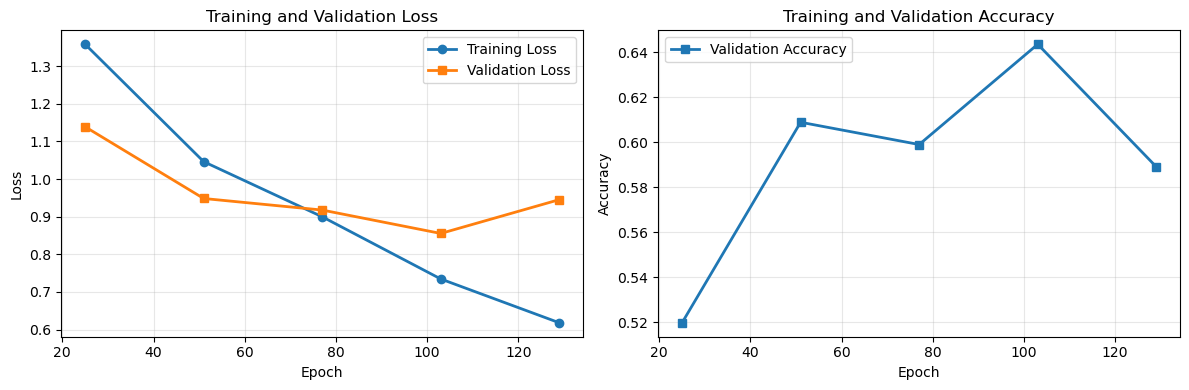

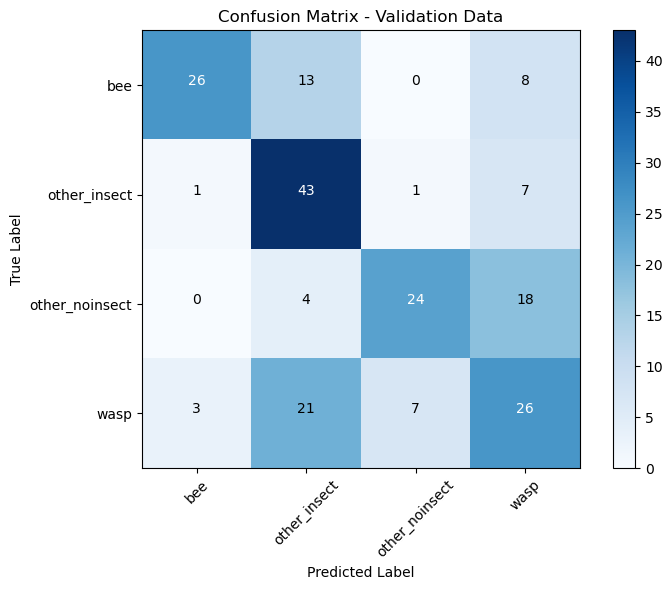

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Per-class Performance:
--------------------------------------------------
            bee: Precision=0.867, Recall=0.553, F1=0.675
   other_insect: Precision=0.531, Recall=0.827, F1=0.647
 other_noinsect: Precision=0.750, Recall=0.522, F1=0.615
           wasp: Precision=0.441, Recall=0.456, F1=0.448

Aggressive regularization model results:


SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|████████████████████████████████| 7/7 [00:00<00:00, 19.51it/s]
──────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5841584205627441
        test_loss           1.0552096366882324
──────────────────────────────────────────────────────────────────────────────────────────

──────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5841584205627441
        test_loss           1.0552096366882324
──────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'val_loss', 'val_acc', 'epoch', 'train_loss_epoch'

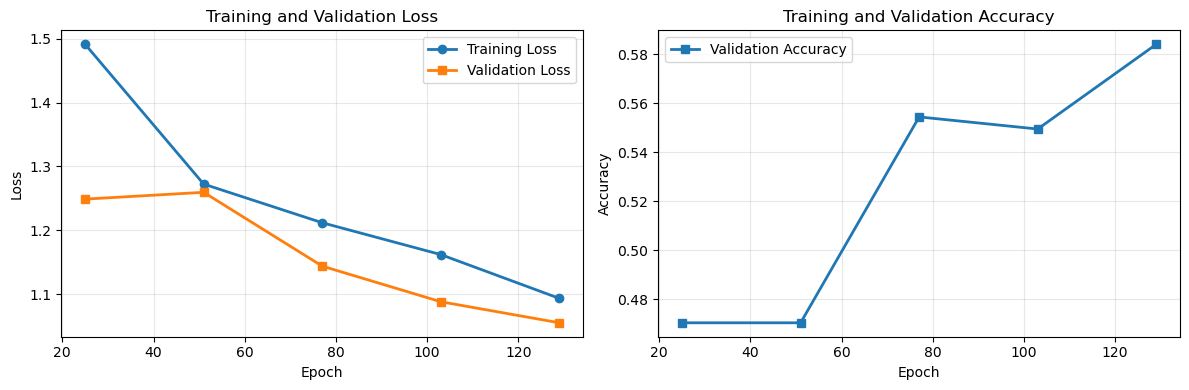

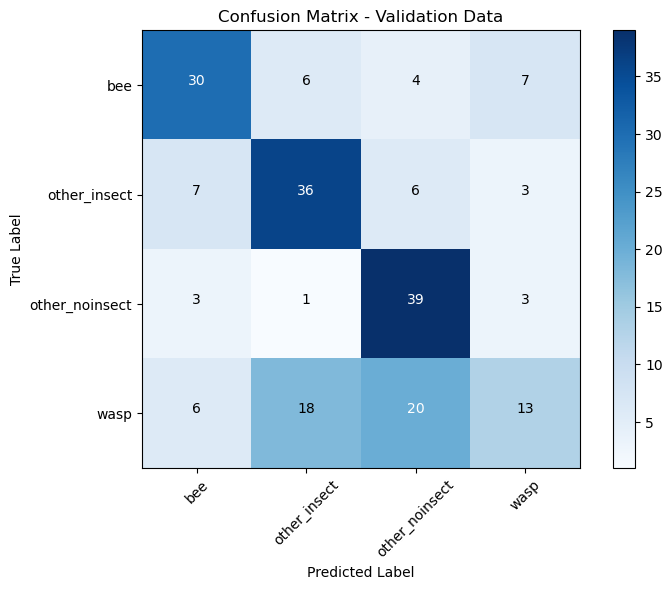


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.652, Recall=0.638, F1=0.645
   other_insect: Precision=0.590, Recall=0.692, F1=0.637
 other_noinsect: Precision=0.565, Recall=0.848, F1=0.678
           wasp: Precision=0.500, Recall=0.228, F1=0.313


[{'test_loss': 1.0552096366882324, 'test_acc': 0.5841584205627441}]

In [12]:
# Let's also try some extreme examples to see the effects more clearly

# Example 3: Very conservative model (low dropout, minimal padding)
print("Training conservative model (low dropout, minimal padding)...")
model_conservative, trainer_conservative = helpers_01.train_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=5,
    dropout_rate=0.1,  # Very low dropout
    conv_padding=0     # No padding (valid convolution)
)

# Example 4: Very aggressive regularization
print("\nTraining highly regularized model...")
model_aggressive, trainer_aggressive = helpers_01.train_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=5,
    dropout_rate=0.8,  # Very high dropout
    conv_padding=2     # High padding
)

print("\nConservative model results:")
helpers_01.test_model(data_module, model_conservative, trainer_conservative)

print("\nAggressive regularization model results:")
helpers_01.test_model(data_module, model_aggressive, trainer_aggressive)